# Convert count to cmass
- For site & species
- Also for species groups
- Regressions forced through 0
    - Intercepts are not signficantly different from 0 (p<0.05)

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.interpolate import interp1d
import sys
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import logging
logging.basicConfig(level=logging.CRITICAL) # ignore no handles to put in legend warning from matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning

from scipy.optimize import curve_fit
import numpy as np
import scipy.odr
import scipy.stats

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 

plot = True


#--- P value calculation
# Calculate p values for both intercept and slope?
force_zero = True 

if force_zero:
    f = sg.mod_linear_origin
else:
    def f(x,b0,b1):
        return b0 + (b1 * x)

In [10]:
#---------------#
#  Import data  #
#---------------#

cols = ['Continent','Country','Region','Site name','Y coords','X coords','Reference','count2cmass_reg_input',
        'MTF basis','MTF','PFT']

#--- Site MTF
site_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Site_MTF')
site_mtf.loc[site_mtf['Site name'].isna(),'Site name'] = ''
site_mtf.loc[site_mtf['Y coords'].isna(),'Y coords'] = ''
site_mtf.loc[site_mtf['X coords'].isna(),'X coords'] = ''
site_mtf_cp = site_mtf.copy()
site_mtf = site_mtf.loc[:, cols]
site_mtf.columns = site_mtf.columns.get_level_values(0)

#--- Species
species_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Species_MTF')
species_mtf.loc[species_mtf['Site name'].isna(),'Site name'] = ''
species_mtf.loc[species_mtf['Y coords'].isna(),'Y coords'] = ''
species_mtf.loc[species_mtf['X coords'].isna(),'X coords'] = ''
species_mtf_cp = species_mtf.copy()
species_mtf = species_mtf.loc[:, cols+['Species']]
species_mtf.columns = species_mtf.columns.get_level_values(0)


Count 22 
Cmass: 22
R2= 0.91 1.9461541632782355
Species 
Count 78 
Cmass: 78
R2= 0.91 1.4802183778309081


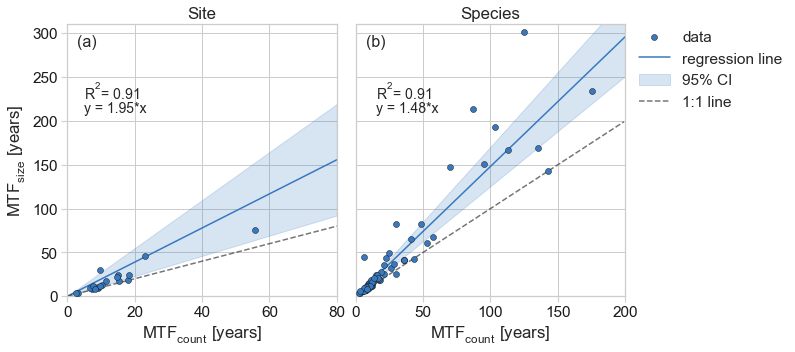

In [11]:
#----------------------------------------------#
#   Linear Regression MTF count vs MTF cmass   #
#----------------------------------------------#

fsize = 14
x1_position = 5
x2_position = 15
y1_position = 225
y2_position = 210

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'

fig, ax = plt.subplots(1,2, figsize=(10,5),sharey=True)

#--- Site level
count_refs = site_mtf[(site_mtf['MTF basis'] == 'count')& 
                      (site_mtf['count2cmass_reg_input'] == True)].Reference.unique().tolist()
cmass_refs = site_mtf[(site_mtf['MTF basis'] == 'cmass') & 
                      (site_mtf['count2cmass_reg_input'] == True)].Reference.unique().tolist()
c_refs = site_mtf[(site_mtf['MTF basis']=='c')].Reference.unique().tolist()
mtf_cmass = site_mtf[site_mtf.Reference.isin(cmass_refs)].copy()


mtf_cmas_melt = mtf_cmass.melt(id_vars = ['MTF basis'], value_vars=['MTF'])
x_site = mtf_cmas_melt[mtf_cmas_melt['MTF basis'] == 'count'].value.values
y_site = mtf_cmas_melt[mtf_cmas_melt['MTF basis'] == 'cmass'].value.values

print('\nCount',len(x_site),'\nCmass:',len(y_site))

#- Regression
popt, pcov = opt.curve_fit(f, x_site, y_site,
                           maxfev= 100000
                          )
X_site = np.linspace(0,80,100)
Y_site = f(X_site, *popt)

slope_site = popt[0]
residuals  = y_site - f(x_site, *popt)                        
ss_res     = np.sum(residuals**2)
ss_tot     = np.sum((y_site -np.mean(y_site))**2)
r_squared_site = 1 - (ss_res / ss_tot)
print('R2=',np.round(r_squared_site,2), *popt)

# Store site slope
site_slope = popt[0]


#- Bootrstraop the 95 CI
X_bts, Y_bts = fcy.draw_bs_pairs_linear(x_site, y_site, size=1000, min_x = 0, max_x = 100)


#- Plot
ax[0].plot(X_site, Y_site, zorder=1)
ax[0].plot(np.arange(0,100),np.arange(0,100), 'k--',alpha=0.6)
ax[0].fill_between(X_site,
                 Y_site-(2*np.std(np.array(Y_bts),axis=0)),
                 Y_site+(2*np.std(np.array(Y_bts),axis=0)),
                 alpha=0.2,color='C0')
sns.scatterplot(x_site, y_site, color='C0', edgecolor='k',ax=ax[0],zorder=3)
ax[0].set_xlim(0,80)
ax[0].set_title('Site')
ax[0].set_ylabel('$MTF_{size}$ [years]')
ax[0].set_xlabel('$MTF_{count}$ [years]')
ax[0].text(x1_position,y1_position, '$R^2$= '+str(np.round(r_squared_site,2)), fontsize=fsize)
ax[0].text(x1_position,y2_position, 'y = '+str(np.round(slope_site,2))+'*x', 
           fontsize=fsize)



#- Species level
mtf_cmass_spe = species_mtf[species_mtf.Reference.isin(cmass_refs)].copy()
mtf_cmas_melt_spe = mtf_cmass_spe.melt(id_vars = ['MTF basis'], value_vars=['MTF'])
x_species = mtf_cmas_melt_spe[mtf_cmas_melt_spe['MTF basis'] == 'count'].value.values
y_species = mtf_cmas_melt_spe[mtf_cmas_melt_spe['MTF basis'] == 'cmass'].value.values

print('Species','\nCount',len(x_species),'\nCmass:',len(y_species))

#- Regression
popt, pcov = opt.curve_fit(f, x_species, y_species,
                           maxfev= 100000
                          )
X_species = np.linspace(0,200,200)
Y_species = f(X_species, *popt)

slope_species     = popt[0]
residuals         = y_species - f(x_species, *popt)                        
ss_res            = np.sum(residuals**2)
ss_tot            = np.sum((y_species -np.mean(y_species))**2)
r_squared_species = 1 - (ss_res / ss_tot)
print('R2=',np.round(r_squared_species,2), *popt)

# Store species slope
species_slope = popt[0]


#- Bootrstraop the 95 CI
X_bts, Y_bts = fcy.draw_bs_pairs_linear(x_species, y_species, size=1000, min_x = 0, max_x = 200)

# Species
sns.scatterplot(x_species, y_species, color='C0', edgecolor='k',ax=ax[1],zorder=3, label='data')
ax[1].plot(X_species, Y_species, label='regression line')

ax[1].fill_between(X_species,
                 Y_species-(2*np.std(np.array(Y_bts),axis=0)),
                 Y_species+(2*np.std(np.array(Y_bts),axis=0)),
                 alpha=0.2,color='C0', label='95% CI')
ax[1].plot(np.arange(0,200),np.arange(0,200), 'k--',alpha=0.6, label='1:1 line')
ax[1].set_ylim(0,310)
ax[1].set_xlim(0,200)
ax[1].set_title('Species')
ax[1].set_ylabel('$MTF_{cmass}$ [years]')
ax[1].set_xlabel('$MTF_{count}$ [years]')
ax[1].text(x2_position,y1_position, '$R^2$= '+str(np.round(r_squared_species,2)), fontsize=fsize)
ax[1].text(x2_position,y2_position, 'y = '+str(np.round(slope_species,2))+'*x', 
           fontsize=fsize)
ax[0].annotate('(a)', (3,285), fontsize=16)
ax[1].annotate('(b)', (8,285), fontsize=16)

ax[1].legend(bbox_to_anchor=(1,1.03), loc='upper left')
leg = ax[1].get_legend()    
leg.set_frame_on(False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ax[0].grid(True, axis='both')
    ax[0].set_yticklabels(np.arange(0,400,50),color='k')
    ax[0].set_xticklabels(np.arange(0,100,20)  ,color='k')

    ax[1].grid(True, axis='both')
    ax[1].set_xticklabels(np.arange(0,300,50),color='k')
    ax[1].yaxis.set_ticks_position('none')

    
plt.subplots_adjust(wspace=0.07)
if plot:
    plt.savefig('Appendix_FigureA4_Site_Species_MTFcount2MTFcmass_reg.png', dpi=300, bbox_inches='tight')
plt.show()


## Replacing the slopes in the function for the count / cmass conversion
#path_filename    = '/Users/antje/Update_PIK/classes/snag_MTF_func.py'
#find_string_list = ['    slope_site_count2cmass = ','    slope_species_count2cmass = ']
#add_number2string_list = np.round([site_slope, species_slope],4)

#for i in range(len(find_string_list)):
#    find_string       = find_string_list[i]
#    add_number2string = add_number2string_list[i]
#    sg.replace_conversion_slope(path_filename, find_string, add_number2string)

# Estimating p-values for the site & species regressions
- Running the regressions with intercept returns non-signficant p-values on the intercept (p>0.05)
- Therefore, really good idea to drop them
    - to see disable the function assignment to sg.mod_linear_origin

In [12]:
bd.print_TITLE('Estimating p-values for count 2 size Regressions')

#--- Estimating p-values for count 2 cmass Regressions

#--- Site
bd.print_header('Site')
x = x_site
y = y_site

def f_wrapper_for_odr(beta, x): # parameter order for odr
    return f(x, *beta)

parameters, cov= curve_fit(f, x, y)

model = scipy.odr.Model(f_wrapper_for_odr)
data = scipy.odr.Data(x,y)
myodr = scipy.odr.ODR(data, model, beta0=parameters,  maxit=0)
myodr.set_job(fit_type=2)
parameterStatistics = myodr.run()
df_e = len(x) - len(parameters) # degrees of freedom, error
cov_beta = parameterStatistics.cov_beta # parameter covariance matrix from ODR
sd_beta = parameterStatistics.sd_beta * parameterStatistics.sd_beta
ci = []
t_df = scipy.stats.t.ppf(0.975, df_e)
ci = []
for i in range(len(parameters)):
    ci.append([parameters[i] - t_df * parameterStatistics.sd_beta[i], parameters[i] + t_df * parameterStatistics.sd_beta[i]])

tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics
pstat_beta = (1.0 - scipy.stats.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values

for i in range(len(parameters)):
    print('parameter:', '%.2f'%parameters[i])
    print('   conf interval:', '%.2f'%ci[i][0], '%.2f'%ci[i][1])
    print('   tstat:', '%.2f'%tstat_beta[i])
    print('   pstat:', '%.2f'%pstat_beta[i])
    print()

    
#--- Species    
bd.print_header('Species')
x = x_species
y = y_species

parameters, cov= curve_fit(f, x, y)

model = scipy.odr.Model(f_wrapper_for_odr)
data = scipy.odr.Data(x,y)
myodr = scipy.odr.ODR(data, model, beta0=parameters,  maxit=0)
myodr.set_job(fit_type=2)
parameterStatistics = myodr.run()
df_e = len(x) - len(parameters) # degrees of freedom, error
cov_beta = parameterStatistics.cov_beta # parameter covariance matrix from ODR
sd_beta = parameterStatistics.sd_beta * parameterStatistics.sd_beta
ci = []
t_df = scipy.stats.t.ppf(0.975, df_e)
ci = []
for i in range(len(parameters)):
    ci.append([parameters[i] - t_df * parameterStatistics.sd_beta[i], parameters[i] + t_df * parameterStatistics.sd_beta[i]])

tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics
pstat_beta = (1.0 - scipy.stats.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values

for i in range(len(parameters)):
    print('parameter:', '%.2f'%parameters[i])
    print('   conf interval:', '%.2f'%ci[i][0], '%.2f'%ci[i][1])
    print('   tstat:', '%.2f'%tstat_beta[i])
    print('   pstat:', '%.2f'%pstat_beta[i])
    print()



             Estimating p-values for count 2 size Regressions             



#----------#
#   Site   #
#----------#

parameter: 1.95
   conf interval: 1.71 2.18
   tstat: 16.99
   pstat: 0.00


#-------------#
#   Species   #
#-------------#

parameter: 1.48
   conf interval: 1.39 1.57
   tstat: 33.28
   pstat: 0.00



Species conifer 
Count 60 
Cmass: 60
R2= 0.9 1.4821619057909423
Species broadleaveed 
Count 18 
Cmass: 18
R2= 0.76 1.2210791180821732


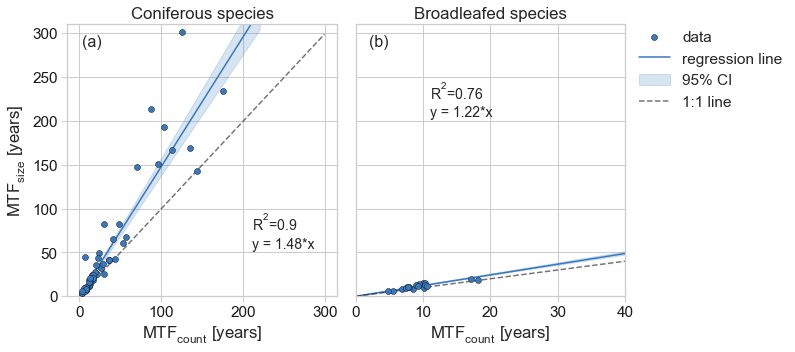

In [13]:
#--- Species groups
linear_regressor = LinearRegression()
pd.options.mode.chained_assignment = None  # default='warn'
conifer_keys = ['fir', 'spruce', 'hemlock', 'pine', 'cedar']

mtf_cmass_spe.loc[:,'Species group bool'] = np.nan
mtf_cmass_spe.loc[:,'Species group']      = np.nan
mtf_cmass_spe.loc[:,'Species group bool'] = mtf_cmass_spe.Species.str.contains("fir|spruce|pine|hemlock|cedar", 
                                                                         case=False)
mtf_cmass_spe.loc[mtf_cmass_spe['Species group bool'] == True, 'Species group']  = 'Conifer'
mtf_cmass_spe.loc[mtf_cmass_spe['Species group bool'] == False, 'Species group'] = 'Broadleaf'
mtf_cmass_conifer   = mtf_cmass_spe[mtf_cmass_spe['Species group'] == 'Conifer'].copy()
mtf_cmass_broadleaf = mtf_cmass_spe[mtf_cmass_spe['Species group'] == 'Broadleaf'].copy()



#- Conifers
mtf_cmass_conifer_melt = mtf_cmass_conifer.melt(id_vars = ['MTF basis'], value_vars=['MTF']).copy()
x_conifer = mtf_cmass_conifer_melt[mtf_cmass_conifer_melt['MTF basis'] == 'count'].value.values
y_conifer = mtf_cmass_conifer_melt[mtf_cmass_conifer_melt['MTF basis'] == 'cmass'].value.values

print('Species conifer','\nCount',len(x_conifer),'\nCmass:',len(y_conifer))
#- Regression
popt, pcov = opt.curve_fit(sg.mod_linear_origin, x_conifer, y_conifer,
                           maxfev= 100000
                          )
X_conifer = np.linspace(0,220,100)
Y_conifer = sg.mod_linear_origin(X_conifer, *popt)

slope_conifer = popt[0]
residuals  = y_conifer - sg.mod_linear_origin(x_conifer, *popt)                        
ss_res     = np.sum(residuals**2)
ss_tot     = np.sum((y_conifer -np.mean(y_conifer))**2)
r_squared_conifer = 1 - (ss_res / ss_tot)
print('R2=',np.round(r_squared_conifer,2), *popt)

# Store conifer slope
conifer_slope = popt[0]

#- Bootrstraop the 95 CI
X_bts_conifer, Y_bts_conifer = fcy.draw_bs_pairs_linear(x_conifer, y_conifer, size=1000, min_x = 0, max_x = 100)

#- Broadleaf
mtf_cmass_broadleaf_melt = mtf_cmass_broadleaf.melt(id_vars = ['MTF basis'], value_vars=['MTF']).copy()
x_broadleaf = mtf_cmass_broadleaf_melt[mtf_cmass_broadleaf_melt['MTF basis'] == 'count'].value.values
y_broadleaf = mtf_cmass_broadleaf_melt[mtf_cmass_broadleaf_melt['MTF basis'] == 'cmass'].value.values

print('Species broadleaveed','\nCount',len(x_broadleaf),'\nCmass:',len(y_broadleaf))
#- Regression
popt, pcov = opt.curve_fit(sg.mod_linear_origin, x_broadleaf, y_broadleaf,
                           maxfev= 100000
                          )
X_broadleaf = np.linspace(0,220,100)
Y_broadleaf = sg.mod_linear_origin(X_broadleaf, *popt)

slope_broadleaf = popt[0]
residuals  = y_broadleaf - sg.mod_linear_origin(x_broadleaf, *popt)                        
ss_res     = np.sum(residuals**2)
ss_tot     = np.sum((y_broadleaf -np.mean(y_broadleaf))**2)
r_squared_broadleaf = 1 - (ss_res / ss_tot)
print('R2=',np.round(r_squared_broadleaf,2), *popt)

# Store broadleaf slope
broadleaf_slope = popt[0]

#- Bootrstraop the 95 CI
X_bts_broadleaf, Y_bts_broadleaf = fcy.draw_bs_pairs_linear(x_broadleaf, y_broadleaf, 
                                                            size=1000, min_x = 0, max_x = 100)


#- Plot
fig, ax = plt.subplots(1, 2,figsize=(10,5), sharey=True)
sns.scatterplot(x_conifer, y_conifer, color='C0', edgecolor='k',ax=ax[0],zorder=3)
ax[0].plot(X_conifer, Y_conifer)
ax[0].fill_between(X_conifer,
                   Y_conifer-(2*np.std(np.array(Y_bts_conifer),axis=0)),
                   Y_conifer+(2*np.std(np.array(Y_bts_conifer),axis=0)),
                   alpha=0.2,color='C0')
ax[0].plot(np.arange(0,300),np.arange(0,300), 'k--',alpha=0.6)
ax[0].text(210,75, '$R^2$='+str(np.round(r_squared_conifer,2)), fontsize=fsize)
ax[0].text(210,55, 'y = '+str(np.round(slope_conifer,2))+'*x',fontsize=fsize)
ax[0].set_title('Coniferous species')
ax[0].set_ylabel('$MTF_{size}$ [years]')
ax[0].set_xlabel('$MTF_{count}$ [years]')
ax[0].set_ylim(0,300)

sns.scatterplot(x_broadleaf, y_broadleaf, color='C0', edgecolor='k',ax=ax[1],zorder=3, label='data')
ax[1].plot(X_broadleaf, Y_broadleaf, label='regression line')
ax[1].fill_between(X_broadleaf,
                   Y_broadleaf-(2*np.std(np.array(Y_bts_broadleaf),axis=0)),
                   Y_broadleaf+(2*np.std(np.array(Y_bts_broadleaf),axis=0)),
                   alpha=0.2,color='C0',label='95% CI')
ax[1].plot(np.arange(0,60),np.arange(0,60), 'k--',alpha=0.6,label='1:1 line')
ax[1].set_title('Broadleafed species')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,310)
ax[1].set_xlabel('$MTF_{count}$ [years]')
ax[1].text(11,225, '$R^2$='+str(np.round(r_squared_broadleaf,2)), fontsize=fsize)
ax[1].text(11,205, 'y = '+str(np.round(slope_broadleaf,2))+'*x', 
          fontsize=fsize)
ax[0].annotate('(a)', (3,285), fontsize=16)
ax[1].annotate('(b)', (2,285), fontsize=16)

ax[1].legend(bbox_to_anchor=(1,1.03), loc='upper left')
leg = ax[1].get_legend()    
leg.set_frame_on(False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ax[0].grid(True, axis='both')
    ax[0].set_yticklabels(np.arange(0,400,50),color='k')
    ax[0].set_xticklabels(np.arange(-100,400,100), color='k')

    ax[1].grid(True, axis='both')
    ax[1].set_xticklabels(np.arange(0,50,10),color='k')
    ax[1].yaxis.set_ticks_position('none')
    
    
plt.subplots_adjust(wspace=0.07)

if plot:
    plt.savefig('Appendix_FigureA5_species_groups_MTFcount2MTFcmass_reg.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
bd.print_TITLE('Estimating p-values for count 2 cmass Regressions between species groups')

#--- Estimating p-values for count 2 cmass Regressions

#--- Site
bd.print_header('Conifer')
x = x_conifer
y = y_conifer

def f_wrapper_for_odr(beta, x): # parameter order for odr
    return f(x, *beta)

parameters, cov= curve_fit(f, x, y)

model = scipy.odr.Model(f_wrapper_for_odr)
data = scipy.odr.Data(x,y)
myodr = scipy.odr.ODR(data, model, beta0=parameters,  maxit=0)
myodr.set_job(fit_type=2)
parameterStatistics = myodr.run()
df_e = len(x) - len(parameters) # degrees of freedom, error
cov_beta = parameterStatistics.cov_beta # parameter covariance matrix from ODR
sd_beta = parameterStatistics.sd_beta * parameterStatistics.sd_beta
ci = []
t_df = scipy.stats.t.ppf(0.975, df_e)
ci = []
for i in range(len(parameters)):
    ci.append([parameters[i] - t_df * parameterStatistics.sd_beta[i], parameters[i] + t_df * parameterStatistics.sd_beta[i]])

tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics
pstat_beta = (1.0 - scipy.stats.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values

for i in range(len(parameters)):
    print('parameter:', '%.2f'%parameters[i])
    print('   conf interval:', '%.2f'%ci[i][0], '%.2f'%ci[i][1])
    print('   tstat:', '%.2f'%tstat_beta[i])
    print('   pstat:', '%.2f'%pstat_beta[i])
    print()

    
#--- Species    
bd.print_header('Broadleaf')
x = x_broadleaf
y = y_broadleaf

parameters, cov= curve_fit(f, x, y)

model = scipy.odr.Model(f_wrapper_for_odr)
data = scipy.odr.Data(x,y)
myodr = scipy.odr.ODR(data, model, beta0=parameters,  maxit=0)
myodr.set_job(fit_type=2)
parameterStatistics = myodr.run()
df_e = len(x) - len(parameters) # degrees of freedom, error
cov_beta = parameterStatistics.cov_beta # parameter covariance matrix from ODR
sd_beta = parameterStatistics.sd_beta * parameterStatistics.sd_beta
ci = []
t_df = scipy.stats.t.ppf(0.975, df_e)
ci = []
for i in range(len(parameters)):
    ci.append([parameters[i] - t_df * parameterStatistics.sd_beta[i], parameters[i] + t_df * parameterStatistics.sd_beta[i]])

tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics
pstat_beta = (1.0 - scipy.stats.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values

for i in range(len(parameters)):
    print('parameter:', '%.2f'%parameters[i])
    print('   conf interval:', '%.2f'%ci[i][0], '%.2f'%ci[i][1])
    print('   tstat:', '%.2f'%tstat_beta[i])
    print('   pstat:', '%.2f'%pstat_beta[i])
    print()



             Estimating p-values for count 2 cmass Regressions between species groups             



#-------------#
#   Conifer   #
#-------------#

parameter: 1.48
   conf interval: 1.38 1.58
   tstat: 29.13
   pstat: 0.00


#---------------#
#   Broadleaf   #
#---------------#

parameter: 1.22
   conf interval: 1.13 1.31
   tstat: 28.15
   pstat: 0.00

